In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
from collections import Counter


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
cuda = False

In [3]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

class FlatMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.n = len(self.dataset)
        
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x.view(28*28), y

    def __len__(self): return self.n
    
tr_ds = FlatMNIST(train_ds)
ts_ds = FlatMNIST(test_ds)

batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 
if cuda:
    train_loader = torch.utils.data.DataLoader(tr_ds, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(ts_ds, batch_size=batch_size, shuffle=False, **kwargs)
else:
    train_loader = torch.utils.data.DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(ts_ds, batch_size=batch_size, shuffle=False)

## Probabilty Tree

Used for intermediate calculations in the tree structure

In [4]:
class prob_tree:
    """
    Recursive class,  Designed for tree calculations 
    up and down the different branches
    """
    def __init__(self, list_prob, node_prob=None, path_prob=None, lvl=1, max_depth=2):
        """
        Initializes the tree. Takes in a list of probabilities 
        corresponding to trees:
        
        listprob = [ root, l, r, ll, lr, rl, rr .....]
        lvl = assumes the current level (increases with recursion)
        max_depth = end condition
        path_prob = probability to REACH the current node, if 
            first node, the probability is 100%
        node_prob = the probability of the current node to the next split
        """
        
        # if there is no path prob, then 100%
        # must be passed 
        if path_prob is None:
            self.path_prob = Variable(torch.ones(list_prob[0].shape))
        else:
            self.path_prob = path_prob
            
        # this is the probability within the current node
        # if node probability isn't passed, pull from list
        if node_prob is None:
            self.prob = list_prob.pop(0)
        else:
            self.prob = node_prob
        
        self.lvl = lvl
        self.max_depth = max_depth
        
        
        # since we are doing breath first searching
        # will pass the node probabilities forward
        if lvl < max_depth:
            left_node_prob = list_prob.pop(0)
            right_node_prob = list_prob.pop(0)
            
            self.left = prob_tree(list_prob, left_node_prob, self.path_prob*self.prob, self.lvl+1, self.max_depth)
            self.right = prob_tree(list_prob, right_node_prob, self.path_prob*(1-self.prob), self.lvl+1, self.max_depth)
        else:
            self.left = None
            self.right = None
            
    def get_leaf_path_probs(self):
        """
        returns a list of path probabilities for only the leaf (recursive)
        """
        if self.left is None:
            return([self.path_prob*self.prob, self.path_prob*(1-self.prob) ])
        else:
            return(self.left.get_leaf_path_probs() + self.right.get_leaf_path_probs())
            
    def get_inner_path_probs(self):
        """
        returns a list of path probabilities for only the inner nodes (recursive)
        uses breath first algorithm
        """        
        path_probs = []
        nodes = [self]
        while nodes:
            current = nodes.pop(0)
            path_probs.append((self.lvl-1,current.path_prob))
            if current.left:
                nodes.append(current.left)
                nodes.append(current.right)
        return(path_probs)


## The Neural Tree Class


In [15]:
class NTree3(nn.Module):
    def __init__(self, tree_depth=3, n_classes=10, ni=28*28, lmbda = 0.1, on_cuda=False, leaf_type ='const'):
        super(NTree3,self).__init__()
        self.n_leaves = 2**tree_depth
        self.n_classes = n_classes
        self.n_nodes = self.n_leaves -1
        self.tree_depth = tree_depth
        self.on_cuda = on_cuda
        self.leaf_type = leaf_type
        self.ptree = None
        
        # regularization
        self.lmbda = lmbda


        leaf_params = [torch.randn(self.n_classes) for i in range(self.n_leaves)]
        beta_params = [torch.rand(1) for i in range(self.n_nodes)]
                
        if self.on_cuda==True:
            beta_params = [beta_param.cuda() for beta_param in beta_params]
            leaf_params = [leaf_param.cuda() for leaf_param in leaf_params]
        
        self.nodes =  nn.ModuleList([nn.Linear(ni, 1) for i in range(self.n_nodes)])
        
        if self.leaf_type == 'const':
            self.leaves = nn.ParameterList([nn.Parameter(leaf_param) for leaf_param in leaf_params])
        elif self.leaf_type == 'logreg':
            self.leaves = nn.ModuleList([nn.Linear(ni, n_classes) for i in range(self.n_leaves)])
                        
        # inverse temperature filter
        self.betas = nn.ParameterList([nn.Parameter(beta) for beta in beta_params])
        
        
    def forward(self, x):
        bz = x.size()[0]
        sigmoid = nn.Sigmoid()
        
        # if we assume constant distribution in the leaft nodes
        if self.leaf_type == 'const': 
            softmax = nn.Softmax(dim=0)
        else: 
            softmax = nn.Softmax(dim=-1)
        
        
        # create distributions at each leaf - store for later
        if self.leaf_type == 'const':
            leaf_pcts = [softmax(leaf_param) for leaf_param in self.leaves]
            leaf_dist = [pct.expand(bz, self.n_classes) for pct in leaf_pcts]
            self.leaf_pcts = leaf_pcts
        else:
            leaf_dist = [softmax(leaf(x)) for leaf in self.leaves]
        
        
        # probabilities of inner nodes
        tmp = [self.nodes[i](x) for i in range(self.n_nodes)]
        
        p_x = [sigmoid(self.betas[i]*self.nodes[i](x)) for i in range(self.n_nodes)]
        
        tmp = [x for x in p_x]
        pt = prob_tree(tmp, max_depth=self.tree_depth)
        
        path_prob = pt.get_leaf_path_probs()
        
        return leaf_dist, path_prob, p_x

### Convolution Tree

In [46]:
class ConvTree(nn.Module):
    def __init__(self, tree_depth=3, n_classes=10, ni=28*28, lmbda = 0.1, on_cuda=False, leaf_type ='const'):
        super(ConvTree,self).__init__()
        self.n_leaves = 2**tree_depth
        self.n_classes = n_classes
        self.n_nodes = self.n_leaves -1
        self.tree_depth = tree_depth
        self.on_cuda = on_cuda
        self.leaf_type = leaf_type
        self.ptree = None
        
        # regularization
        self.lmbda = lmbda


        leaf_params = [torch.randn(self.n_classes) for i in range(self.n_leaves)]
        beta_params = [torch.rand(1) for i in range(self.n_nodes)]
                
        if self.on_cuda==True:
            beta_params = [beta_param.cuda() for beta_param in beta_params]
            leaf_params = [leaf_param.cuda() for leaf_param in leaf_params]
        
        self.conv_nodes = nn.ModuleList([nn.Conv2d(1,6,11) for i in range(self.n_nodes)])
        self.nodes =  nn.ModuleList([nn.Linear(18*18*6, 1) for i in range(self.n_nodes)])
        
        if self.leaf_type == 'const':
            self.leaves = nn.ParameterList([nn.Parameter(leaf_param) for leaf_param in leaf_params])
        elif self.leaf_type == 'conv':
            self.conv_leaves = nn.ModuleList([nn.Conv2d(1,1,11) for i in range(self.n_leaves)])
            self.leaves = nn.ModuleList([nn.Linear(18*18, n_classes) for i in range(self.n_leaves)])
        elif self.leaf_type == 'logreg':
            self.leaves = nn.ModuleList([nn.Linear(ni, n_classes) for i in range(self.n_leaves)])

        # inverse temperature filter
        self.betas = nn.ParameterList([nn.Parameter(beta) for beta in beta_params])
        
        
    def forward(self, x):
        bz = x.size()[0]
        sigmoid = nn.Sigmoid()
        
        # if we assume constant distribution in the leaft nodes
        if self.leaf_type == 'const': 
            softmax = nn.Softmax(dim=0)
        else: 
            softmax = nn.Softmax(dim=-1)
        
        
        # create distributions at each leaf - store for later
        if self.leaf_type == 'const':
            leaf_pcts = [softmax(leaf_param) for leaf_param in self.leaves]
            leaf_dist = [pct.expand(bz, self.n_classes) for pct in leaf_pcts]
            self.leaf_pcts = leaf_pcts
        elif self.leaf_type == 'conv':
            conv_calc = [self.conv_leaves[i](x) for i in range(self.n_leaves)]
            conv_calc2 = [conv_out.view(bz,-1) for conv_out in conv_calc]
            leaf_dist = [softmax(leaf(conv_calc2[idx])) for idx, leaf in enumerate(self.leaves)]
        elif self.leaf_type == 'logreg':
            leaf_dist = [softmax(leaf(x.view(bz,-1))) for idx, leaf in enumerate(self.leaves)]
        
        # probabilities of inner nodes
        conv_calc = [self.conv_nodes[i](x) for i in range(self.n_nodes)]
        conv_calc2 = [conv_out.view(bz,-1) for conv_out in conv_calc]
        p_x = [sigmoid(self.betas[i]*self.nodes[i](conv_calc2[i])) for i in range(self.n_nodes)]
        
        tmp = [x for x in p_x]
        pt = prob_tree(tmp, max_depth=self.tree_depth)
        
        path_prob = pt.get_leaf_path_probs()
        
        return leaf_dist, path_prob, p_x

In [42]:
def bigot_leaf_loss(path_prob, leaf_dist, labels, on_cuda):
    ymask = torch.FloatTensor(leaf_dist.size()).zero_()
    if on_cuda:
        ymask = ymask.cuda()    
    ymask.scatter_(1, labels.data.view(-1,1), 1)
    ymask = Variable(ymask)
    Tk_log_Qk = (torch.log(leaf_dist) * ymask).sum(1)
    PTQ = Tk_log_Qk[:,None]*path_prob
    return torch.sum(PTQ)


def penalty(p_x, max_depth, lmbda=0.1):
    
    tmp = [x for x in p_x]
    ptree = prob_tree(tmp, max_depth=max_depth)
    P_x = ptree.get_inner_path_probs()
    
    alphas = [(Px[0], torch.sum(torch.mul(Px[1],px))/torch.sum(Px[1])) for px, Px in zip(p_x, P_x)]
    
    def c1(alpha_i):
        return 0.5*np.log(alpha_i) + 0.5*np.log(1-alpha_i)

    C =  np.sum([-lmbda*2**-depth*c1(alp) for depth, alp in alphas])
    return C

def total_loss(path_probs, leaf_dists, p_x, labels, max_depth, lmbda=0.1,  on_cuda=False):
    L_x = [bigot_leaf_loss(path_prob, leaf_dist, labels, on_cuda) for path_prob, leaf_dist in zip(path_probs, leaf_dists)]
    C = penalty(p_x, max_depth, lmbda)
    return(torch.log(-torch.sum(torch.stack(L_x)))+C)


def which_node(path_prob, n_leaves, on_cuda=False):
    node_id = torch.max(torch.stack(path_prob),dim=0)[1]    
    nodes_onehot = torch.FloatTensor(path_prob[0].size()[0], n_leaves).zero_()
    if on_cuda:
        node_id = node_id.cuda()
        nodes_onehot = nodes_onehot.cuda()
    node_mask = nodes_onehot.scatter_(1, node_id.data,1)
    return(node_id,node_mask)


def which_class(path_prob, leaf_dist, on_cuda=False):
    n_leaves = len(leaf_dist)
    node_id, node_mask = which_node(path_prob, n_leaves, on_cuda)
    max_class_per_node = torch.t(torch.max(torch.stack(leaf_dist),dim=2)[1])
    pred_class = torch.sum(Variable(node_mask.long())*max_class_per_node,dim=1)
    return(pred_class)


def acc_calc(val_dl, model, on_cuda=False):
    model.eval()
    val_ = iter(val_dl)
    correct = 0
    total = 0
    final_dist = 0

    for i, batch in enumerate(val_dl):
        data, labels = batch
        if on_cuda:
                data, labels = data.cuda(), labels.cuda()
        data_var, labels_var = Variable(data), Variable(labels)        
        leaf_dist, path_prob, p_nodes = model(data_var)
        final_dist += which_node(path_prob, n_leaves = model.n_leaves, on_cuda=on_cuda)[1].sum(0)
        
        preds = which_class(path_prob, leaf_dist, on_cuda=on_cuda)
        match = labels.eq(preds.data)
        correct += match.sum()
        total += match.size()[0]
    return(correct/total, correct, total, final_dist) 

def plt_node_dist(leaf_pcts):
    """
    .store_preds() must be run by calling .predict()
    """
    n_leaves = len(leaf_pcts)
    n_half = int(n_leaves/2) 
    fig, ax_array = plt.subplots(2, n_half, sharey=True)
    fig.set_figwidth(12)
    plt.setp(ax_array, xticks=[0,1,2,3,4,5,6,7,8,9])
    plt.subplots_adjust(hspace=0.5)
    for i, leaf_pct in enumerate(leaf_pcts):
        pct_dict = {k:v for k,v in enumerate(leaf_pct.data.numpy())}
        x = list(pct_dict.keys())
        y = list(pct_dict.values())
        if i < n_half:
            ax_array[0,i].bar(x, height=y)
            ax_array[0,i].set_title('Node %d' % i)
        else:
            ax_array[1,i-n_half].bar(x, height=y)
            ax_array[1,i-n_half].set_title('Node %d' % i)


In [43]:
def split_idx(batch_prob, master_tensor):
    EMPTY_TENSOR = torch.zeros(1).nonzero()
    local_prob = batch_prob.index_select(dim=0, index=Variable(master_tensor[:,0].long()))
    left_mask = local_prob > 0.5
    right_mask = local_prob <= 0.5
    
    l = left_mask.nonzero()
    r = right_mask.nonzero()
    
    if len(l)>0:    
        left_mask_idx = l[:,0].data    
        left_idx = master_tensor.index_select(dim=0,index=left_mask_idx)
    else:
        left_idx = EMPTY_TENSOR
        
    if len(r)>0:
        right_mask_idx = r[:,0].data
        right_idx = master_tensor.index_select(dim=0,index=right_mask_idx)
    else:
        right_idx = EMPTY_TENSOR
    return(left_idx, right_idx)


def distribute_points(labels_var, p_x, max_depth):
    EMPTY_TENSOR = torch.zeros(1).nonzero()
    master_list = [(i,v) for i, v in enumerate(labels_var.data)]
    master_tensor = torch.Tensor(master_list)

    output = [master_tensor]
    idx_queue = [master_tensor]
    tmp = [a for a in p_x]
    
    iter_limit = 2**(max_depth)
    counter = 1
    while counter < iter_limit:
        counter +=1
        current_prob = tmp.pop(0)
        current_labels = idx_queue.pop(0)

        left_labels, right_labels = split_idx(current_prob, current_labels)
        if len(left_labels) > 0:
            output.append(left_labels)
            idx_queue.append(left_labels)
        else:
            output.append(EMPTY_TENSOR)

        if len(right_labels) > 0 :
            output.append(right_labels)
            idx_queue.append(right_labels)
        else:
            output.append(EMPTY_TENSOR)
    return(output)

def add_index(tensor, offset):
    tensor[:,0] = tensor[:,0] + offset
    return(tensor)

def spread_test_distr(bz, model, test_loader):
    max_depth = model.tree_depth
    test_loader = iter(test_loader)
    master_points_dist = {i:[] for i in range(2**(max_depth+1)-1)}
    
    for i, batch in enumerate(test_loader):
        img_data, labels = batch
        img_data_var, labels_var = Variable(img_data), Variable(labels)
        leaf_dist, path_prob, p_x = model(img_data_var)
        
        # initialize
        
        points_dist = distribute_points(labels_var, p_x, max_depth)
        for i, tensor in enumerate(points_dist):
            master_points_dist[i].append(tensor)
            
            
    
    for k, v in master_points_dist.items():
        master_points_dist[k] = torch.cat([add_index(tensor, j*bz) for j, tensor in enumerate(v) if len(tensor) > 0],dim=0)

    return master_points_dist

def plot_test_tree_spread(bz, model, test_loader):
    max_depth = model.tree_depth
    res = spread_test_distr(bz, model, test_loader)
    tmp = [a for a in res.values()]


    for i in range(0,max_depth+1):
        fig, ax_array = plt.subplots(1, 2**i, sharey=True)
        fig.set_size_inches(14,4)
        for j in range(2**i):
            tensor = tmp.pop(0)
            ctr = dict(Counter(tensor[:,1]))
            x = list(ctr.keys())
            y = list(ctr.values())
            if i == 0:
                ax_array.bar(x, height=y)
            else:
                ax_array[j].bar(x, height=y)
                
                    

### Training for a log model at leafs

In [44]:
is_cuda = False
lmbda = 0.1
max_depth = 2
kwargs = {'num_workers': 1, 'pin_memory': True}

# flattened
if is_cuda:
    train_loader = torch.utils.data.DataLoader(tr_ds, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(ts_ds, batch_size=batch_size, shuffle=False, **kwargs)
else:
    train_loader = torch.utils.data.DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(ts_ds, batch_size=batch_size, shuffle=False)

    
model = NTree3(tree_depth=max_depth, n_classes=10, ni=28*28, lmbda = lmbda, on_cuda=is_cuda, leaf_type='logreg')

if is_cuda:
    model.cuda()
    
n_epochs = 5
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dl = iter(train_loader)
final_dist = 0

for epoch in range(n_epochs):
    running_loss = 0.0
    train_dl = iter(train_loader)
    
    for i, batch in enumerate(train_dl):
        data, labels = batch
        bz = data.size()[0]
        if is_cuda:
            data = data.cuda()
            labels = labels.cuda()
        data_var, labels_var = Variable(data), Variable(labels)
       
            
        optimizer.zero_grad()
        leaf_dist, path_prob, p_x = model(data_var)
        
        loss = total_loss(path_prob, leaf_dist, p_x, labels_var, max_depth, lmbda, is_cuda)
        loss.backward()
        optimizer.step()
        
        if i%200 == 0:
            acc, correct, total, dist = acc_calc(test_loader, model, on_cuda=is_cuda)
            print('Ep: %d , %05d/60000,  L: %.03f, A: %.04f, dist %s' % (epoch, i*bz ,loss.data[0], acc, list(dist.long().cpu().numpy())))

         

Ep: 0 , 00000/60000,  L: 5.247, A: 0.2314, dist [139, 943, 6624, 2294]


KeyboardInterrupt: 

### Conv Nodes, Log Leafs

In [ ]:
is_cuda = False
lmbda = 0.1
max_depth = 3
kwargs = {'num_workers': 1, 'pin_memory': True}

# flattened
if is_cuda:
    train_loader = torch.utils.data.DataLoader(tr_ds, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(ts_ds, batch_size=batch_size, shuffle=False, **kwargs)
else:
    train_loader = torch.utils.data.DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(ts_ds, batch_size=batch_size, shuffle=False)

    
# not flattened
if is_cuda:
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)
else:
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)


    
model = ConvTree(tree_depth=max_depth, n_classes=10, ni=28*28, lmbda = lmbda, on_cuda=is_cuda, leaf_type='logreg')

if is_cuda:
    model.cuda()
    
n_epochs = 5
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dl = iter(train_loader)
final_dist = 0

for epoch in range(n_epochs):
    running_loss = 0.0
    train_dl = iter(train_loader)
    
    for i, batch in enumerate(train_dl):
        data, labels = batch
        bz = data.size()[0]
        if is_cuda:
            data = data.cuda()
            labels = labels.cuda()
        data_var, labels_var = Variable(data), Variable(labels)
       
            
        optimizer.zero_grad()
        leaf_dist, path_prob, p_x = model(data_var)
        
        loss = total_loss(path_prob, leaf_dist, p_x, labels_var, max_depth, lmbda, is_cuda)
        loss.backward()
        optimizer.step()
        
        if i%200 == 0:
            acc, correct, total, dist = acc_calc(test_loader, model, on_cuda=is_cuda)
            print('Ep: %d , %05d/60000,  L: %.03f, A: %.04f, dist %s' % (epoch, i*bz ,loss.data[0], acc, list(dist.long().cpu().numpy())))

         

Ep: 0 , 00000/60000,  L: 5.530, A: 0.1611, dist [569, 822, 6428, 1764, 38, 229, 65, 85]
Ep: 0 , 12800/60000,  L: 3.903, A: 0.9226, dist [1281, 766, 1398, 1962, 1417, 975, 1124, 1077]
Ep: 0 , 25600/60000,  L: 3.007, A: 0.9346, dist [1330, 898, 1355, 1669, 1227, 1033, 935, 1553]
Ep: 0 , 38400/60000,  L: 2.749, A: 0.9395, dist [1688, 1410, 891, 1322, 1168, 1161, 1342, 1018]
Ep: 0 , 51200/60000,  L: 3.162, A: 0.9433, dist [851, 1019, 1665, 1228, 1385, 1214, 1300, 1338]
Ep: 1 , 00000/60000,  L: 3.696, A: 0.9437, dist [1611, 1415, 1228, 983, 882, 888, 1415, 1578]
Ep: 1 , 12800/60000,  L: 2.236, A: 0.9467, dist [1397, 1146, 1360, 969, 1433, 732, 1498, 1465]
Ep: 1 , 25600/60000,  L: 3.324, A: 0.9486, dist [1706, 1370, 982, 1029, 932, 1008, 1415, 1558]
Ep: 1 , 38400/60000,  L: 2.481, A: 0.9498, dist [1309, 1289, 1147, 787, 1302, 1290, 1352, 1524]
Ep: 1 , 51200/60000,  L: 3.748, A: 0.9452, dist [1304, 1371, 1151, 1082, 1328, 1136, 1136, 1492]
Ep: 2 , 00000/60000,  L: 2.975, A: 0.9478, dist [803,

### Viewing constant distributions

In [66]:
#plt_node_dist(model.leaf_pcts)

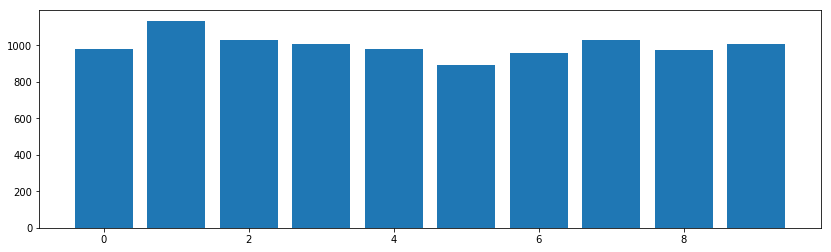

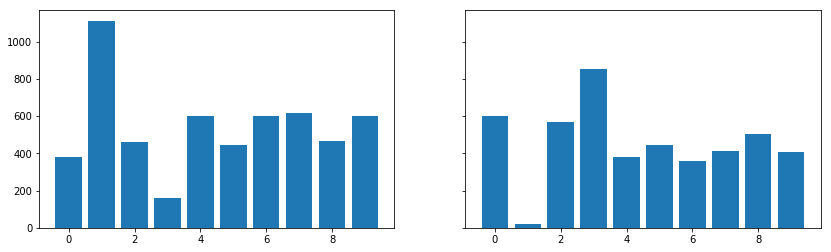

In [67]:
plot_test_tree_spread(bz, model, test_loader)

In [61]:
model.nodes

ModuleList(
  (0): Linear(in_features=784, out_features=1)
  (1): Linear(in_features=784, out_features=1)
  (2): Linear(in_features=784, out_features=1)
  (3): Linear(in_features=784, out_features=1)
  (4): Linear(in_features=784, out_features=1)
  (5): Linear(in_features=784, out_features=1)
  (6): Linear(in_features=784, out_features=1)
)

ModuleList(
  (0): Linear(in_features=784, out_features=1)
)